# Lockdown Multilevel Model - Random Intercept & Random Slopes

In [1]:
import os
sys.path.append("C:\\Users\\Andrew\\OneDrive - University College London\\_PhD\\Papers - Drafts\\J5_JASA_Lockdown-SS")

from scripts import lockdown_mlm as mlm
import pandas as pd
from pathlib import Path
import numpy as np
import time
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scripts import lockdown_mlm_rirs as rirs

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks")
sns.set_context("paper", font_scale=1.4)

# Define some constants and options
## variables
dep_vars = ["Natural", "Traffic", "Human", "Other", "loudness", "overall", "Pleasant", "Eventful"]

FEATS_LISTS = mlm.FEATS_LISTS
remove = ["FS_TEMP", "LAeq_TEMP", "LCeq_TEMP", "LZeq_TEMP", "I_TEMP", "N_TEMP", "R_TEMP", "S_TEMP", "SIL_TEMP", "THD_TEMP", "T_TEMP"]

for k in remove:
    FEATS_LISTS.pop(k, None)

acoustic_vars = sorted({x for v in FEATS_LISTS.values() for x in v})

## processing options
nonlinear_transformations = [] # Leave a blank list to do no transformations
criterion = "aic"


## Load Data

In [2]:
DATA_DIR = Path("C:\\Users\\Andrew\\OneDrive - University College London\\_PhD\\Papers - Drafts\\J5_JASA_Lockdown-SS\\data")
ssidData = pd.read_csv(DATA_DIR.joinpath("2020-08-13\\LondonVeniceBINResults_2020-08-13_4.csv"))

for col_name in ["Lockdown"]:
    ssidData[col_name] = ssidData[col_name].astype('category')

# Cutdown the dataset
cols = ["GroupID", "LocationID", "SessionID", "Lockdown"] + dep_vars + acoustic_vars
ssidData = ssidData[cols]

# Compress to mean of each GroupID
# compressData = ssidData.copy()
compressData = ssidData.groupby(["GroupID"]).mean()
compressData = compressData.merge(ssidData[["GroupID", "LocationID", "SessionID", "Lockdown"]].drop_duplicates(),  on="GroupID")

location_codes = pd.Categorical(compressData["LocationID"]).codes
compressData["LocationID_codes"] = location_codes
compressData.loc[compressData["Lockdown"] == 1].dropna(inplace=True)
compressData = compressData.dropna(subset=acoustic_vars)

compressData, acoustic_vars = mlm.nonlinear_features(compressData, acoustic_vars, transformations=nonlinear_transformations)
print(f"Initial features number: {len(acoustic_vars)}")

# Standardise
from sklearn.preprocessing import StandardScaler
compressData = compressData.replace([np.inf, -np.inf], np.nan)
compressData = compressData.dropna(subset=acoustic_vars)
scaler = StandardScaler()
compressData[acoustic_vars] = scaler.fit_transform(compressData[acoustic_vars])
print(compressData.shape)
compressData.head()

Initial features number: 119
(1235, 132)


,GroupID,Natural,Traffic,Human,Other,loudness,overall,Pleasant,Eventful,FS,...,T_5,T_50,T_5_T_95,T_90,T_95,T_Max,LocationID,SessionID,Lockdown,LocationID_codes
1,AM02,3.500000,2.000000,4.0,1.500000,3.500000,4.500000,0.426777,0.000000,0.413252,...,1.649423,2.011723,1.511154,2.462967,1.556501,1.074239,SanMarco,SanMarco1,1,8
4,AM06,1.500000,1.000000,3.5,4.000000,2.500000,3.000000,0.176777,0.103553,0.855149,...,0.653030,1.303535,0.438749,2.420644,1.884355,0.985136,SanMarco,SanMarco1,1,8
5,AM07,4.000000,1.000000,4.0,1.000000,3.000000,5.000000,0.707107,0.707107,0.172807,...,0.268539,1.033749,0.148569,1.468388,1.028079,0.371321,SanMarco,SanMarco1,1,8
6,CT101,1.666667,3.666667,3.0,2.333333,3.333333,2.666667,-0.229780,0.284518,0.120819,...,1.625979,0.106359,1.694822,-0.137751,-0.096266,2.064264,CamdenTown,CamdenTown1,1,0
7,CT102,1.000000,3.000000,4.0,2.000000,3.000000,2.000000,0.103553,-0.750000,0.179306,...,0.592074,0.494176,0.556180,0.609241,0.449514,0.311919,CamdenTown,CamdenTown1,1,0


In [3]:
prelockdownData = compressData.loc[compressData["Lockdown"] == 1]
prelockdownData = prelockdownData.dropna()
print(prelockdownData.shape)
prelockdownData.head()

(661, 132)


,GroupID,Natural,Traffic,Human,Other,loudness,overall,Pleasant,Eventful,FS,...,T_5,T_50,T_5_T_95,T_90,T_95,T_Max,LocationID,SessionID,Lockdown,LocationID_codes
1,AM02,3.500000,2.000000,4.0,1.500000,3.500000,4.500000,0.426777,0.000000,0.413252,...,1.649423,2.011723,1.511154,2.462967,1.556501,1.074239,SanMarco,SanMarco1,1,8
4,AM06,1.500000,1.000000,3.5,4.000000,2.500000,3.000000,0.176777,0.103553,0.855149,...,0.653030,1.303535,0.438749,2.420644,1.884355,0.985136,SanMarco,SanMarco1,1,8
5,AM07,4.000000,1.000000,4.0,1.000000,3.000000,5.000000,0.707107,0.707107,0.172807,...,0.268539,1.033749,0.148569,1.468388,1.028079,0.371321,SanMarco,SanMarco1,1,8
6,CT101,1.666667,3.666667,3.0,2.333333,3.333333,2.666667,-0.229780,0.284518,0.120819,...,1.625979,0.106359,1.694822,-0.137751,-0.096266,2.064264,CamdenTown,CamdenTown1,1,0
7,CT102,1.000000,3.000000,4.0,2.000000,3.000000,2.000000,0.103553,-0.750000,0.179306,...,0.592074,0.494176,0.556180,0.609241,0.449514,0.311919,CamdenTown,CamdenTown1,1,0


In [4]:
lockdownData = compressData.loc[compressData["Lockdown"] == 2]
print(lockdownData.shape)
lockdownData.head()

(573, 132)


,GroupID,Natural,Traffic,Human,Other,loudness,overall,Pleasant,Eventful,FS,...,T_5,T_50,T_5_T_95,T_90,T_95,T_Max,LocationID,SessionID,Lockdown,LocationID_codes
63,CT501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.529030,...,-0.148774,0.038912,-0.166844,0.238919,0.102375,-0.459311,CamdenTown,CamdenTown5,2,0
64,CT502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.557624,...,0.275572,0.865132,0.235429,0.600777,0.395514,-0.431590,CamdenTown,CamdenTown5,2,0
65,CT503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.080634,...,0.064571,-0.359022,0.102470,-0.387454,-0.283335,1.757356,CamdenTown,CamdenTown5,2,0
66,CT504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.198801,...,-0.104229,-0.028534,-0.092601,-0.146215,-0.121337,-0.084091,CamdenTown,CamdenTown5,2,0
67,CT505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.243096,...,0.723363,0.266544,0.748825,0.023075,-0.001767,-0.123692,CamdenTown,CamdenTown5,2,0


In [5]:
from sklearn.model_selection import train_test_split
prelockdownTrain, prelockdownTest = train_test_split(prelockdownData, test_size = 0.25, random_state = 42)

## Random Intercept Random Slope Forward step feature selection
## Pleasant Model


### Partial Correlation

In [6]:
Pleasant_features = mlm.par_cors(prelockdownData, "Pleasant", FEATS_LISTS, "LocationID")
Pleasant_features

{'FS_90': -0.16815853772915498,
 'FS_Max_FS_Min': -0.051678308627210755,
 'LAeq_5': -0.38917682007928833,
 'LAeq_5_LAeq_95': -0.2068793908060405,
 'LCeq_5': -0.42606252083971663,
 'LCeq_5_LCeq_95': -0.23071475114611886,
 'LZeq_10': -0.36914293438232915,
 'LZeq_5_LZeq_95': -0.16279617064422558,
 'N_5': -0.36269940040558835,
 'N_10_N_90': -0.35895331418517495,
 'R_95': -0.46564445861853965,
 'R_10_R_90': -0.15166140236662398,
 'S_Max': -0.15426211767767947,
 'S_Max_S_Min': -0.24027472011384676,
 'SIL_Max': -0.38662511049999737,
 'SIL_5_SIL_95': -0.2505788020188675,
 'T_50': -0.2306626180245416,
 'T_10_T_90': -0.21056111592585358,
 'I_90': -0.1104436105377557,
 'I_5_I_95': -0.04876027521261827,
 'THD_Max': -0.1988313835770569,
 'THD_Max_THD_Min': -0.08727923744057609,
 'PeakSpectralCentroid': -0.07276444180534489}

In [7]:
Pleasant_model_rirs = rirs.rirs_forward_step(prelockdownData, response = "Pleasant", features = list(Pleasant_features.keys()), groups = "LocationID", criterion = "aic", verbose=1)

1|2|3|4|5|

Pleasant ~ LZeq_10 + LAeq_5 + PeakSpectralCentroid + I_5_I_95
                     Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         Pleasant 
No. Observations:          661             Method:                     ML       
No. Groups:                13              Scale:                      0.0840   
Min. group size:           11              Log-Likelihood:             -147.4786
Max. group size:           81              Converged:                  No       
Mean group size:           50.8                                                 
--------------------------------------------------------------------------------
                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                              0.286    0.043  6.652 0.000  0.202  0.370
LZeq_10                               -0.055    0.028 -1.986 0.047 -0

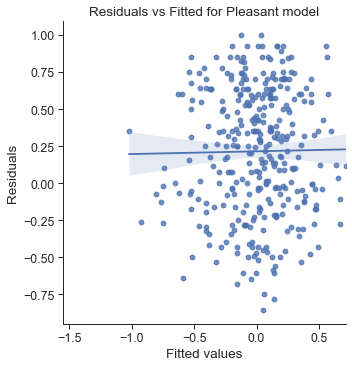

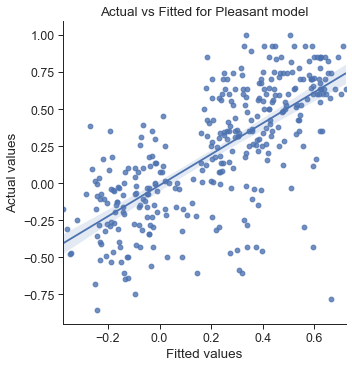

Adj R-sq:  0.43667844809767653


In [8]:
rirs.summarise_rirs(Pleasant_model_rirs, prelockdownData)

In [9]:
Pleasant_model_rirs, Pleasant_vif = rirs.rirs_vif_reduction(Pleasant_model_rirs, prelockdownData, "Pleasant", groups="LocationID")
Pleasant_vif

No VIF issues identified.


const                   1.590367
LZeq_10                 2.404495
LAeq_5                  2.595958
PeakSpectralCentroid    1.446895
I_5_I_95                1.034990
dtype: float64

## Eventful Model

In [10]:
Eventful_features = mlm.par_cors(prelockdownData, "Eventful", FEATS_LISTS, "LocationID")
Eventful_features

{'FS_95': 0.17061711610988423,
 'FS_Max_FS_Min': 0.0645880944784227,
 'LAeq_5': 0.3784767417571867,
 'LAeq_10_LAeq_90': 0.17759886916392137,
 'LCeq': 0.35973989450551014,
 'LCeq_5_LCeq_95': 0.09244573639544762,
 'LZeq_95': 0.31974643527716706,
 'LZeq_5_LZeq_95': 0.03372532180366254,
 'N_5': 0.3469384880819474,
 'N_5_N_95': 0.3230035814510419,
 'R_90': 0.3790768109241406,
 'R_10_R_90': 0.19030251266558657,
 'S_Max': 0.10277118359605983,
 'S_5_S_95': 0.1620171385314496,
 'SIL_5': 0.3704436103915315,
 'SIL_5_SIL_95': 0.1983618438162803,
 'T_50': 0.2903826499606057,
 'T_10_T_90': 0.25665513406653184,
 'I_95': 0.09146802693614563,
 'I_10_I_90': -0.022873202758591157,
 'THD_Max': 0.24757172708886827,
 'THD_Max_THD_Min': 0.032342950979929445,
 'MaxFreq': 0.12756599434973925}

1|2|3|4|5|6|No VIF issues identified.
Eventful ~ R_90 + LZeq_95 + SIL_5_SIL_95 + S_5_S_95 + T_50
                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Eventful
No. Observations:       661           Method:                   ML      
No. Groups:             13            Scale:                    0.0639  
Min. group size:        11            Log-Likelihood:           -46.0423
Max. group size:        81            Converged:                No      
Mean group size:        50.8                                            
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.103    0.022  4.664 0.000  0.060  0.146
R_90                           0.082    0.049  1.688 0.091 -0.013  0.177
LZeq_95                        0.023    0.043

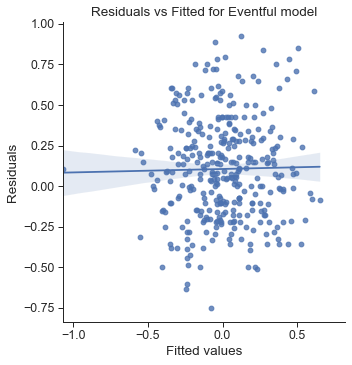

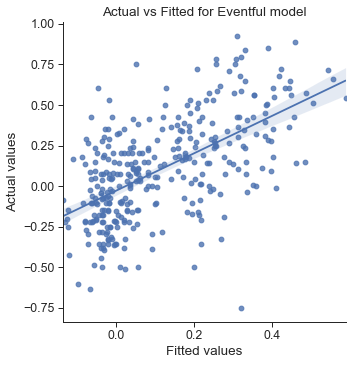

Adj R-sq:  0.2646995440579025


In [11]:
Eventful_model_rirs = rirs.rirs_forward_step(prelockdownData, response = "Eventful", features = list(Eventful_features.keys()), groups = "LocationID", criterion = "aic", verbose=1)
Eventful_model_rirs, Eventful_vif = rirs.rirs_vif_reduction(Eventful_model_rirs, prelockdownData, "Eventful", groups="LocationID")
rirs.summarise_rirs(Eventful_model_rirs, prelockdownData)

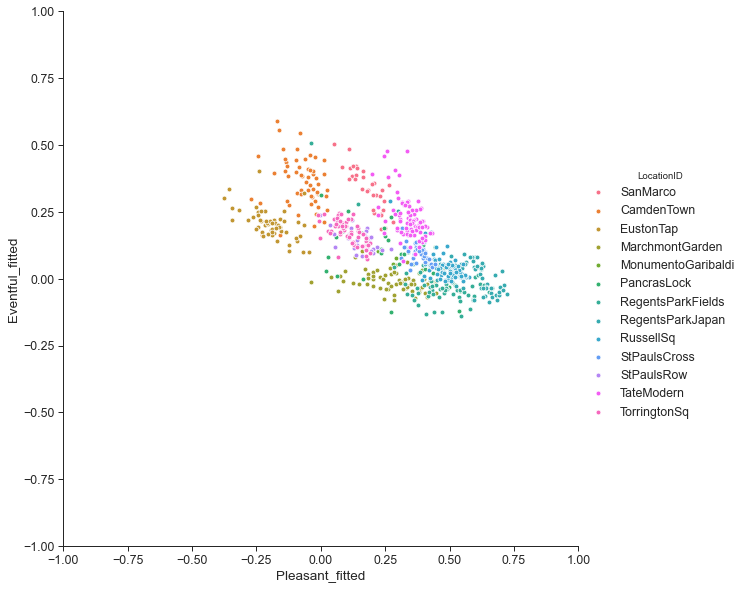

In [16]:
prelockdownData["Pleasant_fitted"] = Pleasant_model_rirs.fittedvalues
prelockdownData["Eventful_fitted"] = Eventful_model_rirs.fittedvalues

ps = sns.pairplot(x_vars=["Pleasant_fitted"], y_vars=["Eventful_fitted"], data = prelockdownData, hue="LocationID", size = 8)
ps.set(xlim = (-1,1))
ps.set(ylim= (-1,1))

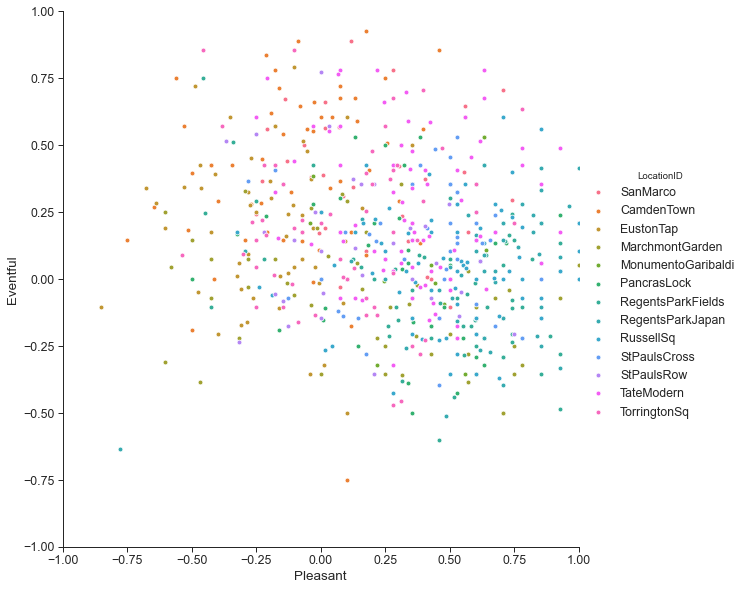

In [17]:
a = sns.pairplot(x_vars=["Pleasant"], y_vars=["Eventful"], data = prelockdownData, hue="LocationID", size = 8)
a.set(xlim = (-1,1))
a.set(ylim= (-1,1))

In [18]:
prelockdownSummary = prelockdownData[["LocationID", "Eventful", "Eventful_fitted", "Pleasant", "Pleasant_fitted"]].groupby(['LocationID']).mean()
prelockdownSummary['LocationID'] = prelockdownSummary.index
prelockdownSummary

,Eventful,Eventful_fitted,Pleasant,Pleasant_fitted,LocationID
LocationID,,,,,
CamdenTown,0.389827,0.361376,-0.085017,-0.076035,CamdenTown
EustonTap,0.189456,0.206644,-0.212548,-0.194157,EustonTap
MarchmontGarden,-0.045435,-0.010851,0.267471,0.272650,MarchmontGarden
MonumentoGaribaldi,0.057862,0.059282,0.379609,0.371189,MonumentoGaribaldi
PancrasLock,0.064004,0.086433,0.279305,0.293587,PancrasLock
RegentsParkFields,-0.040805,-0.019248,0.466470,0.463077,RegentsParkFields
RegentsParkJapan,0.018787,0.006751,0.632678,0.613416,RegentsParkJapan
RussellSq,0.041965,0.041650,0.489734,0.484851,RussellSq
SanMarco,0.376335,0.332647,0.187516,0.181216,SanMarco


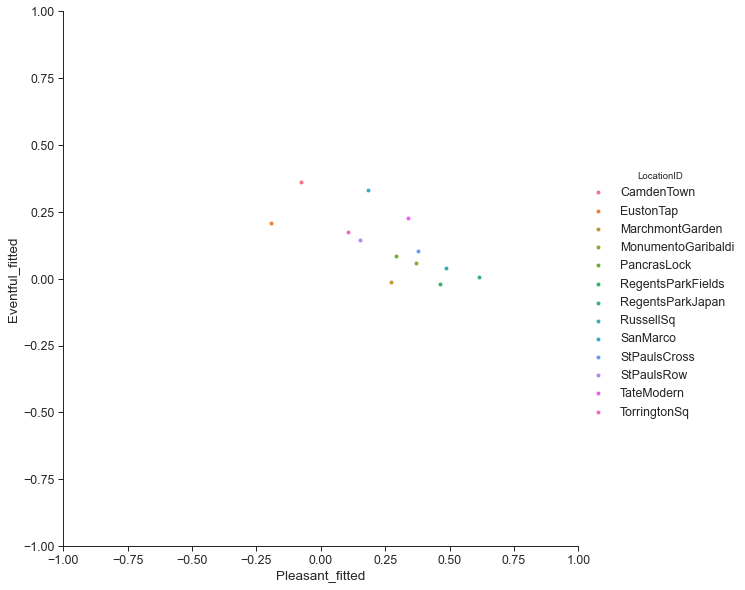

In [19]:
ps = sns.pairplot(x_vars=["Pleasant_fitted"], y_vars=["Eventful_fitted"], data = prelockdownSummary, hue="LocationID", size = 8)
ps.set(xlim = (-1,1))
ps.set(ylim= (-1,1))

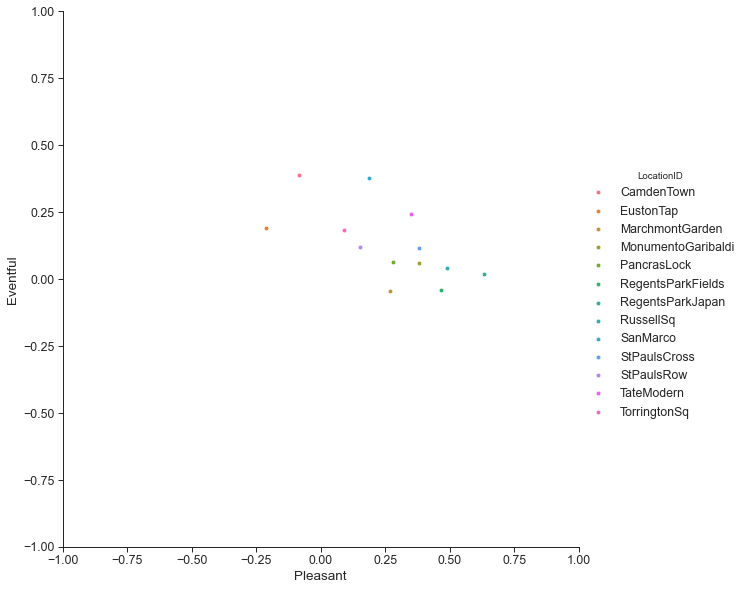

In [20]:
a = sns.pairplot(x_vars=["Pleasant"], y_vars=["Eventful"], data = prelockdownSummary, hue="LocationID", size = 8)
a.set(xlim = (-1,1))
a.set(ylim= (-1,1))